In [1]:
import numpy as np
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
import scipy.interpolate as interp
import scipy.stats as st
import scipy.signal as sig
from scipy.optimize import curve_fit


import h5py
import gc
import sys
import subprocess
import pickle
import os


import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP7


import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from __future__ import unicode_literals

rcParams["font.family"] = "DejaVu Sans"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

In [41]:
os.chdir("/Users/nitya/Work/Paper2/mpl7")

drpall = t.Table.read('drpall-v2_4_3.fits')
drpall.add_index('plateifu')
#drpall.loc['9487-12701']
# drp_logcube2 = fits.open('manga-9487-12701-LOGCUBE.fits')
index = np.where(drpall2['srvymode']=='MaNGA dither')[0]
#print(len(np.unique(drpall2['plateifu'][index])))
#print(np.unique(drpall2['plateifu'][index][0:10]))
plate_ifu = drpall2['plateifu'][index]

In [42]:
drp_logcube = fits.open('manga-7977-12701-LOGCUBE.fits' )
wave = drp_logcube['WAVE'].data

In [47]:
#dn4000
def dn4000_red(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    red_wav = np.linspace(4000,4100,100)
    d4000_r = np.sum(interp_spec(red_wav))
    return d4000_r

def dn4000_blue(wave,spec):
    interp_spec = interp.interp1d(wave,spec)
    blue_wav = np.linspace(3850,3950,100)
    d4000_b =  np.sum(interp_spec(blue_wav))
    return d4000_b

def dn_4000(wave,specs):
    dn_4000 = np.sum([dn4000_red(wave,specs[i]) for 
                      i in range(len(specs))]) / np.sum([dn4000_blue(wave,specs[i]) for 
                                                         i in range(len(specs))])
    return dn_4000

In [44]:
#Hdelta
bandw_HdA = np.logical_and(wave > 4083.500, wave < 4122.250)   # analogous to MPA-JHU
bandw_HdA_blueside = np.logical_and(wave > 4041.600, wave < 4079.750)
bandw_HdA_redside = np.logical_and(wave > 4128.500, wave < 4161.000)
blues = len(wave[bandw_HdA_blueside])
reds = len(wave[bandw_HdA_redside])

def tsum(xin, yin):
    tsum = np.sum(np.abs((xin[1:]-xin[:-1]))*(yin[1:]+yin[:-1])/2. )
    return tsum

def HdA(specs):
    spec_av_blueside = np.sum([np.sum(specs[i][bandw_HdA_blueside]) 
                               for i in range(len(specs))])/(blues*len(specs))
    spec_av_redside = np.sum([np.sum(specs[i][bandw_HdA_redside]) 
                               for i in range(len(specs))])/(reds*len(specs))
    
    a_spec = (spec_av_redside - spec_av_blueside)/((4161.000+4128.500)/2 
                                                   - (4079.750+4041.600)/2)
    b_spec = spec_av_blueside - a_spec * (4079.750+4041.600)/2
    spec_cont_HdA = wave[bandw_HdA] * a_spec + b_spec
                              
    mean_dip = np.mean([specs[i][bandw_HdA] for i in range(len(specs))])
    HdA = tsum(wave[bandw_HdA], np.divide(spec_cont_HdA - mean_dip, spec_cont_HdA))
    return HdA

In [45]:
#For each galaxy, all the spaxels under 3"

def get_specs(galaxy, NX, NY):

    x_ax = np.arange(0, NX) + 0.5 - (NX/2.0)
    y = np.outer((np.arange(0, NX) + 0.5) - (NX/2.0), np.ones(NX))
    x = np.transpose(y)
    grid = np.sqrt((x*x+y*y))
    
    #unravel the cube
    spectra = []
    for i in range(NX):
        for j in range(NY):
            thing = galaxy[:,i,j]
            spectra.append(thing)
    spectra = np.array(spectra)

    #3 arcsec aperture 
    radii = np.ravel(grid)
    index = np.where(radii<=3.0)[0]
    spaxels_within = spectra[index]
    
    return(spaxels_within)


In [50]:
fits_files = ['manga-'+ str(plate_ifu[i]) + '-LOGCUBE.fits' for i in range(10)]
#IFU dimensions
n = []
dn4 = []
hda = []
for i in range(len(fits_files)):
    drp_logcube = fits.open(fits_files[i])
    wave = drp_logcube['WAVE'].data
    #print(wavez)
    NL, NY, NX = drp_logcube['FLUX'].data.shape
    n.append([NX,NY])
    flux = drp_logcube['FLUX'].data
    
    specs = get_specs(flux, NX, NY)
    hdelta = HdA(specs)
    dn4000 = dn_4000(wave,specs)
    dn4.append(dn4000)
    hda.append(hdelta)

#get_g = np.vectorize(get_galaxies)

In [51]:
print(dn4, hda)

[1.0891782565593018, 1.440270722608165, 1.1614174782865332, 1.1280200433415852, 1.05496047819599, 1.0442278144539379, 1.259637422502666, 1.111068313392984, 1.2968871705750307, 1.12034109587386] [-6.151703374318438, 11.969096795361374, -4.547217298501929, -6.081360479555746, 3.881927680646249, -0.8878219235333611, 4.732618202463739, -4.47641081769025, -12.390461620350887, -7.608349977609652]


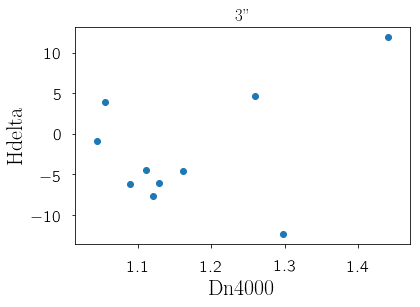

In [52]:
plt.scatter(dn4,hda)
plt.xlabel('Dn4000')
plt.ylabel('Hdelta')
plt.title('3"')
plt.show()

(100, 2)


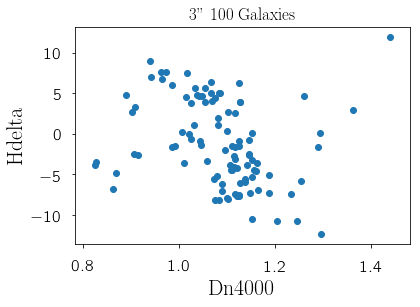

In [56]:
file2 = open(r'3_arcsec', 'rb')
d = pickle.load(file2, encoding = 'latin')
file2.close()
print(np.shape(d))
plt.scatter(d[:,0],d[:,1])
plt.xlabel('Dn4000')
plt.ylabel('Hdelta')
plt.title('3" 100 Galaxies')
plt.show()

(250, 2)


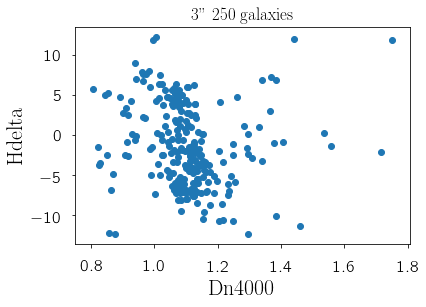

In [57]:
file2 = open(r'3_arcsec_250_galaxies', 'rb')
d = pickle.load(file2, encoding = 'latin')
file2.close()
print(np.shape(d))
plt.scatter(d[:,0],d[:,1])
plt.xlabel('Dn4000')
plt.ylabel('Hdelta')
plt.title('3" 250 galaxies')
plt.show()